`TO BE UPDATED`

Files needed for this demo from the resources folder:
* tabulated_logE_sindec_aeff_upgoing.pckl (see core/aeff_calculations.py)
* MCEq_flux.pckl (see core/atmospheric_background.py)
* energy_smearing_2D.pckl (see notebooks/misc/energy_resolution.ipynb)
This is a notebook to demonstrate in a 'stand-alone' version how to do a diffuse astrophysical flux fit and LLH ratio test

Further reference: https://pos.sissa.it/395/1185/ , especially sec. 2.2

In [2]:
%load_ext autoreload
%autoreload 2

# Preparations

In [30]:
# need to run if there are updates to resolution, binning, or mephistograms
%run ../../core/resolution.py
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/energy_smearing_2D_step-0.1.pckl
140 log_10(energy) bins
90 declination bins
140 log_10(energy) bins
90 declination bins
Elementary arithmetic possible.
True


# Imports

In [41]:
import pickle
from os.path import join
from collections import namedtuple

import numpy as np
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2
from settings import * # contains all flux parameters
from resolution import energy_smearing


# Default binning

In [23]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))

141 2.0 8.999999999999975
140 2.0 8.949999999999974
91 -1.0 1.0


# Source parameters

In [24]:
# livetime of 10yrs in seconds and days
print(LIVETIME, LIVETIME / 24 / 3600)
# Normalization energy of power law (E/E_NORM)^GAMMA_ASTRO
print(E_NORM) # in GeV
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
print(GAMMA_ASTRO) # spectral index
print(PHI_ASTRO) # neutrinos * (E/E_NORM)^GAMMA_ASTRO / GeV / cm^2 / s / sr
print(BASEPATH)
print(LOCALPATH)

275270400 3186.0
100000.0
2.37
1.44e-18
/home/lisajsch/repos/Plenum
/home/lisajsch/repos/Plenum/local


# Functions

In [25]:
help(get_mids)

Help on function get_mids in module tools:

get_mids(bins, ext=False)
    Calculate the bin mids from an array of bin edges.



In [26]:
help(energy_smearing)

Help on function energy_smearing in module resolution:

energy_smearing(ematrix, ev)
    Matrix multiplication with the energy resolution
    to translate an event histogram from E_true to E_reco.
    
    Expected formats: -- WIP --
    ev:



In [27]:
help(atmo_background)

Help on function atmo_background in module fluxes:

atmo_background(aeff_factor, bckg_vals, energy_resolution=None)
    Calculate the number of neutrinos of atmospheric background flux
    as a function neutrino energy or reconstructed energy.
    
    If aeff_factor is 2D, eg. in sin(dec) and log(E_true),
    the result will also be 2D, in sin(dec) and log(E_reco) then.
    
    Parameters:
    aeff_factor: array
        effective area multiplied with binning and livetime
    bckg_vals: atmospheric background flux binned the same way as aeff_factor
    energy_resolution: Optional
        If the energy resolution matrix is given,
        calculate the background events for reconstructed energy;
        If None, return background events for true neutrino energy



In [28]:
help(calc_aeff_factor)

Help on function calc_aeff_factor in module aeff_calculations:

calc_aeff_factor(aeff, ewidth, livetime, **config)
    WIP
    Calculate the effective area multiplied with the correct bin widths
    for the flux integration and the livetime.
    
    Parameters:
    -----------
    aeff:
    
    ewidth:
    
    livetime:
    
    
    Keyword Parameters:
    -------------------
    diff_or_ps: default 'ps'
    
    dec: default 0
    
    sindec_mids: no default given
    
    sindec_width: no default given
    
    dpsi_max: default 0
    
    grid_2d: default 1



# Get the effective area

In [31]:
with open(join(LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])


dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])
Mephistogram with 2 dimensions and shape (140, 90). Axis names are ('log(E/GeV)', 'sin(dec)').
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.26320470e+01
  1.63779054e+01 1.91394358e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.26320470e+01
  1.63779054e+01 1.91394358e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.56772486e+01
  1.99083412e+01 2.29770471e+01]
 ...
 [1.83251197e+07 1.87444592e+07 1.94647909e+07 ... 2.49199371e+01
  2.08290051e+01 1.87043008e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


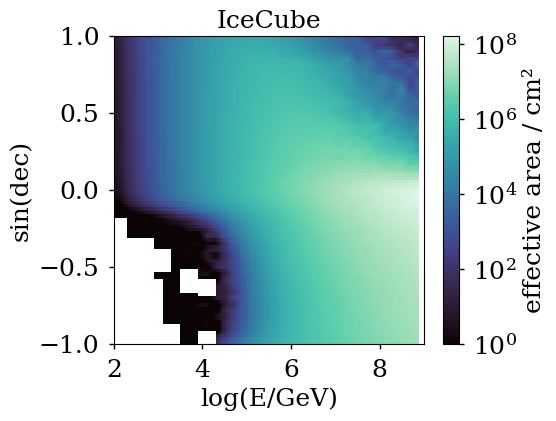

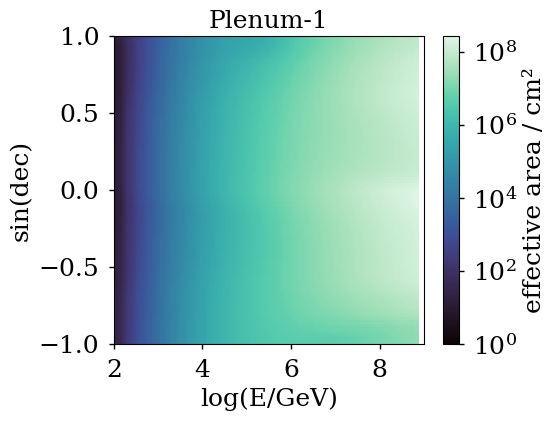

In [35]:
# plot the effective area
for key in ["IceCube", "Plenum-1"]:
    aeff_2d[key].plot(norm=LogNorm(vmin=1))
    cb = plt.colorbar()
    cb.set_label("effective area / cm²")
    plt.title(key)

# Background

In [36]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histograms are matching, i.e. have the same binning
print(bckg_histo.match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


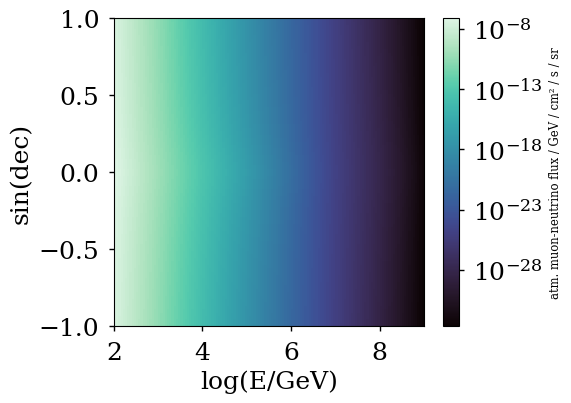

In [38]:
# visualization of bckg flux
bckg_histo.plot(norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")

# Energy smearing

In [39]:
# energy smearing matrix
with open(join(LOCALPATH, "energy_smearing_MH_up.pckl"), "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize()

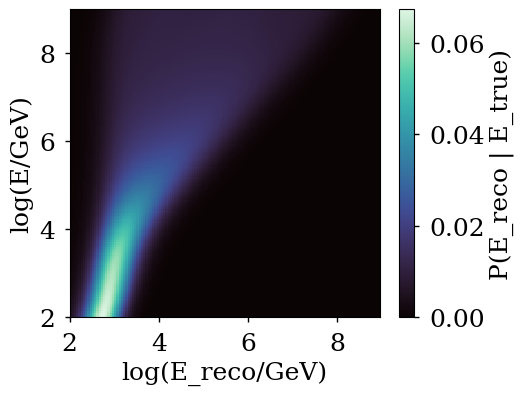

In [40]:
baseline_eres.plot()
cb = plt.colorbar()
cb.set_label("P(E_reco | E_true)")

# Source flux definition

$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $ 

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [42]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")

In [43]:
help(astro_flux)

Help on function astro_flux in module fluxes:

astro_flux(aeff_factor, emids, energy_resolution, phi_scaling, flux_shape)
    Wrapper for different astro flux shapes to put into TS minimizer.
    flux_shape must be a named tuple
    
    Possible shapes and their parameters:
    
    ° powerlaw:
        - norm
        - gamma
    
    ° powerlaw * cutoff:
        - norm
        - gamma
        - e_cut
    
    ° log-parabola:
        - norm
        - alpha
        - beta
    
    ° double powerlaw:
        - norm
        - gamma_1 (E < E_Break)
        - gamma_2 (E >= E_Break)
        - e_break
    
    ° powerlaw * dip/bump:
        - norm
        - gamma
        - amplitude --- sign of amplitude is defined by 'dip' or 'bump'
        - e_mean
        - width
    
    ° powerlaw * sigmoid:
        - norm
        - gamma
        - depletion
        - growth_rate
        - e_trans



# Config

In [47]:
# generic diffuse flux config
diffuse_config = dict(
    sindec_mids=sindec_mids,
    sindec_width=sindec_width,
    livetime=LIVETIME,
    ewidth=ewidth,
    diff_or_ps="diff"
)

### Full nominal (=Asimov) histograms in  sin(dec) - log(E)

Fit parameters for analysis:
* Global normalization of the atmospheric neutrino flux (background), $N_B$
* Global normalization of the astrophysical neutrino flux (signal), $N_S$
* Spectral index, GAMMA_ASTRO, of the astrophysical neutrino flux (signal), $\gamma$

In [48]:
calc_aeff_factor(aeff_2d["IceCube"], **diffuse_config)

TypeError: unsupported operand type(s) for *: 'method' and 'float'

In [14]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d, sindec_width, ewidth) * LIVETIME
)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals, normed_kvals)
k_s = astro_flux(
    aeff_factor,
    emids,
    E_NORM,
    GAMMA_ASTRO, ## FIT PARAMETER
    1, ## FIT PARAMETER
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b)) # ~673312
print("Signal:", np.sum(k_s)) # ~2888
print("S+B", np.sum(k_i)) # ~676201




Asimov data sum:
Background: 673312.6074227438
Signal: 2888.920442481476
S+B 676201.5278652253


## some plotting of the event distribution

Text(0.5, 1.0, 'Signal astrophysical flux')

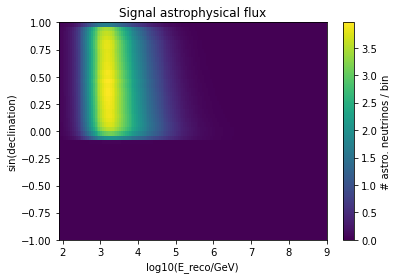

In [15]:
## signal
plt.pcolormesh(logE_reco_bins, sindec_bins, k_s)
cb = plt.colorbar()
cb.set_label("# astro. neutrinos / bin")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Signal astrophysical flux")

Text(0.5, 1.0, 'Background atmospheric flux')

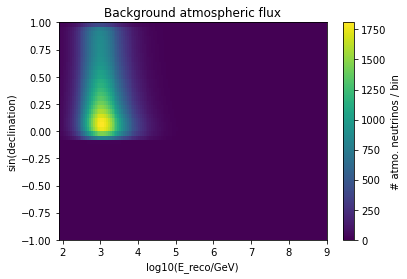

In [16]:
## atmo. background
plt.pcolormesh(logE_reco_bins, sindec_bins, k_b)
cb = plt.colorbar()
cb.set_label("# atmo. neutrinos / bin")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Background atmospheric flux")

Text(0.5, 1.0, 'Combined neutrino flux')

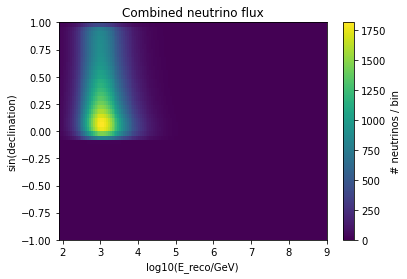

In [17]:
## atmo. background + astro. signal
plt.pcolormesh(logE_reco_bins, sindec_bins, k_i)
cb = plt.colorbar()
cb.set_label("# neutrinos / bin")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Combined neutrino flux")

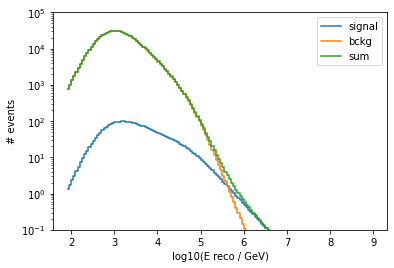

In [18]:
# summed 1D hist in log(E_reco)
plt.plot(logE_reco_mids, k_s.sum(axis=0), ds="steps-mid", label="signal")
plt.plot(logE_reco_mids, k_b.sum(axis=0), ds="steps-mid", label="bckg")
plt.plot(logE_reco_mids, k_i.sum(axis=0), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlabel("log10(E reco / GeV)")
plt.ylabel("# events")
plt.ylim(1E-1, 1E5)
plt.legend()

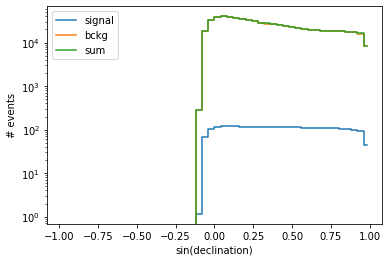

In [19]:
# summed 1D hist in sin(dec)
plt.plot(sindec_mids, k_s.sum(axis=1), ds="steps-mid", label="signal")
plt.plot(sindec_mids, k_b.sum(axis=1), ds="steps-mid", label="bckg")
plt.plot(sindec_mids, k_i.sum(axis=1), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlabel("sin(declination)")
plt.ylabel("# events")
plt.legend()

### DEMO: Significance test Background vs. Background + Signal

$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \GAMMA_ASTRO\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know
For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
$-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
            - \mu_i
            - 0.5 \cdot \log(2 \pi \cdot k_i)
            + k_i
            - k_i \cdot \log(k_i))$

In [20]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E_NORM,
):
    """
    Define the Log-Likelihood function depending
    on the model parameters (=fit parameters)
    
    fit parameters (= x) for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E_NORM_NGC
    phi_0: normalization flux, default PHI_NGC
    """

    mu_b = atmo_background(
        mu_b_base, bckg_flux_vals * x[0], normed_kvals
    )
    mu_s = astro_flux(
        mu_s_base, emids, e_0, *x[1:]
    )
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (L) - L=Poisson
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )
 

The significance of the hypothesis test is evaluated using the test statistic

$TS = -2 \log ( H_0(\mu = {\rm best fit}) / H_1(\mu = {\rm best fit}) )$

where the best-fit parameters are obtained with an optimization function `fmin_l_bfgs_b`.


The data (k) is modeled as 'Asimov data', the TS calculation fulfills the requirements of Wilks' theorem, and thus we know that the underlying TS distribution
follows a $\chi ^2$ distribution, here with 2 degrees of freedom.

The p-value of the Asimov data set represents the expected significance of an analysis with real data if it has the same model parameters. It's the integral of the $\chi ^2$ distribution from TS to infinity (`chi.sf(TS)`). The p-value in terms of Gaussian standard deviations can be calculated via the inverse error function (`erfinv`).

In [21]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d, sindec_width, ewidth) * LIVETIME
)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals, normed_kvals)
k_s = astro_flux(
    aeff_factor,
    emids,
    E_NORM,
    GAMMA_ASTRO, ## FIT PARAMETER
    1, ## FIT PARAMETER
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b)) # ~673312
print("Signal:", np.sum(k_s)) # ~2888
print("S+B", np.sum(k_i)) # ~676201

aeff_factor = (
    aeff_eval_e_sd(aeff_2d, sindec_width, ewidth) * LIVETIME
)

# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 2, 0), aeff_factor, aeff_factor, k_i
)
# background + signal, 3 free parameters
global_llh = lambda x: ps_llh_2d_composite(
    x, aeff_factor, aeff_factor, k_i
)
# ... and fit both hypotheses!
# background first
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Bckg-only normalization:", out_bckg[0])
# .. then signal+background
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

## Note: out_bckg/comp[1] contains the value of the
# LLH function with the optimized model parameters
# out_bckg[1] - out_comp[1] == -2log(L(H_0) / L(H_1)) = TS (see above)

# calculate p-value and significance with Wilks' theorem and 2 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


Asimov data sum:
Background: 673312.6074227438
Signal: 2888.920442481476
S+B 676201.5278652253
Bckg-only normalization: [1.0042906]
Signal fit parameters: [0.99999943 2.3700677  1.00002791]
P-VALUE: 2.4755945656516476e-12 SIGNIFICANCE: 7.004676292334277
